# Joining University Data and Ed Attainment to Patents: Agg and Non Agg

## Outline

__Initial Processing__
- Read in university, crosswalk, patent data via Box API
- Join universities to GEOIDs

__University Matching__

- Create dictionary for research universities to patent assignees pairs via fuzzy matching and other qa/qc
- Use dictionary to clean assignee names

__Granular Data__

- Join assignees to research university list
- Join ed attainment data to each patent by GEOID and app year
- This create data by patent with university and ed attainment info

__Aggregate Data__

- Aggregate patent stats by app year and geoid
- Join research universities/geoid
- Join ed attainment data by geoid and app year


### Things in progress:

- Still some errors picking up all universities
- Re call in GEOIDs as strings


## Pulling University Data, Crosswalk Data, and Patents Data (used later) From Box

In [309]:
from boxsdk import DevelopmentClient
import pandas as pd
import dotenv
import os
from io import BytesIO

In [310]:
env_location =  'C:\\Users\\trent\\Documents\\Capstone' ##change as necessaru
os.chdir(env_location)
dotenv.load_dotenv() # register the .env file where passwords are stored

True

In [311]:
CLIENT_ID = os.getenv("box_client_id")
CLIENT_SECRET = os.getenv("box_client_secret")
TOKEN = 'i3HIU6s54sa4McBgeAtWIpx1MTyLuDhp' ##copy and paste from dev

In [312]:
from boxsdk import OAuth2, Client

oauth = OAuth2(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    access_token=TOKEN,
)

box = Client(oauth)

me = box.user().get()

print('logged into Box as', me.login)

logged into Box as txc5ve@virginia.edu


In [313]:
MY_FOLDER_ID = 0
my_folder = box.folder(MY_FOLDER_ID).get()
my_folder
items = my_folder.get_items()
items
for i in items:
    print(i)

<Box Folder - 166970315293 (Patents22)>


In [314]:
universities_box_id = '988549931799'
universities_file = box.file(universities_box_id).get()

In [315]:
universities_content = box.file(universities_box_id).content()

In [316]:
universities = pd.read_csv(BytesIO(universities_content))

In [317]:
## crosswalk not used for join
crosswalk_box_id = '990881584176'
crosswalk_file = box.file(crosswalk_box_id).get()
crosswalk_file
crosswalk_content = box.file(crosswalk_box_id).content()
crosswalk = pd.read_csv(BytesIO(crosswalk_content))

C:\Users\trent\AppData\Local\Temp\ipykernel_33700\1472077329.py:6: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  crosswalk = pd.read_csv(BytesIO(crosswalk_content))


In [318]:
patents_box_id = '995479549488'
patents_file = box.file(crosswalk_box_id).get()
patents_file
patents_content = box.file(patents_box_id).content()
patents = pd.read_csv(BytesIO(patents_content))

C:\Users\trent\AppData\Local\Temp\ipykernel_33700\3393662229.py:5: DtypeWarning: Columns (0,6) have mixed types. Specify dtype option on import or set low_memory=False.
  patents = pd.read_csv(BytesIO(patents_content))


In [319]:
# patents_box_id = '987961636758'
# patents_file = box.file(patents_box_id).get()
# patents_file
# patents_content = box.file(patents_box_id).content()
# patents = pd.read_csv(BytesIO(patents_content))

In [320]:
universities

,Unnamed: 0,Institution,Control,City,State,level
0,0,Arizona State University Campus Immersion,Public,Tempe,AZ,r1
1,1,Auburn University,Public,Auburn,AL,r1
2,2,Baylor University,Private (non-profit),Waco,TX,r1
3,3,Binghamton University,Public,Vestal,NY,r1
4,4,Boston College,Private (non-profit),Chestnut Hill,MA,r1
...,...,...,...,...,...,...
297,18,University of Texas Health Science Center at H...,Public,Houston,TX,r3
298,19,University of Texas Health Science Center at S...,Public,San Antonio,TX,r3
299,20,University of Texas Medical Branch,Public,Galveston,TX,r3
300,21,University of Texas Southwestern Medical Center,Public,Dallas,TX,r3


In [321]:
crosswalk.head(5)

,id,GEOID,pv_city,gl_city,pv_state,gl_state,country,pv_lat,gl_lat,pv_long,gl_long,pv_county,gl_county,pv_state_fips,pv_county_fips,gl_county_fips
0,f9139cb2-cb8f-11eb-9615-121df0c29c1e,6075,San Francisco,NaN,CA,NaN,US,37.7292,NaN,-123.0470,NaN,San Francisco,NaN,6.0,6075.0,NaN
1,ffc9f8bd-cb8e-11eb-9615-121df0c29c1e,32031,Reno,NaN,NV,NaN,US,39.5504,NaN,-119.8030,NaN,Washoe,NaN,32.0,32031.0,NaN
2,9596257a-cb90-11eb-9615-121df0c29c1e,50021,Rutland,NaN,VT,NaN,US,43.6106,NaN,-72.9726,NaN,Rutland,NaN,50.0,50021.0,NaN
3,499f8deb-cb8e-11eb-9615-121df0c29c1e,34003,Parkridge,Park Ridge,NJ,NJ,US,NaN,-74.03939,NaN,41.03379,NaN,Bergen,34.0,NaN,34003.0
4,ea59a211-09be-11ec-893a-12de62d610b1,6085,Sunnyvale,NaN,CA,NaN,US,37.3688,NaN,-122.0360,NaN,Santa Clara,NaN,6.0,6085.0,NaN


## Cleaning Data for Join on City/State

In [322]:
universities.City = universities.City.str.lower()
universities.State = universities.State.str.lower()
universities.dtypes

Unnamed: 0      int64
Institution    object
Control        object
City           object
State          object
level          object
dtype: object

In [323]:
##crosswalk ultimately not used due to the typos in city names
crosswalk.pv_city = crosswalk.pv_city.str.lower()
crosswalk.pv_state = crosswalk.pv_state.str.lower()
crosswalk.dtypes
crosswalk.query("pv_city == 'chestnut hill'")

,id,GEOID,pv_city,gl_city,pv_state,gl_state,country,pv_lat,gl_lat,pv_long,gl_long,pv_county,gl_county,pv_state_fips,pv_county_fips,gl_county_fips
2777,e297d56d-cb8e-11eb-9615-121df0c29c1e,25017,chestnut hill,Newton,ma,MA,US,42.3268,-71.17208,-71.1646,42.33295,NaN,Middlesex,25.0,NaN,25017.0


In [324]:
# patents.pv_city = patents.pv_city.str.lower()
# patents

## Joining on City and State - Universities and Cross Walks

#### Fix Missing Cities first

In [325]:
universities['City']= universities['City'].replace('saint louis', 'st. louis')
universities['City']= universities['City'].replace('mount pleasant', 'mt. pleasant')

## this one listed wrong in wikipedia table, rio grande valley is not a city
universities['City']= universities['City'].replace('rio grande valley', 'edinburg')

### Join

In [326]:
university_geo_join = pd.merge(universities, crosswalk, left_on=['City', 'State'], right_on=['pv_city','pv_state'], how='left')

In [327]:
university_geo = university_geo_join[['Institution', 'Control', 'City', 'State', 'level', 'GEOID', 'pv_city', 'pv_state', 'pv_county']]

In [328]:
university_geo

,Institution,Control,City,State,level,GEOID,pv_city,pv_state,pv_county
0,Arizona State University Campus Immersion,Public,tempe,az,r1,4013,tempe,az,Maricopa
1,Auburn University,Public,auburn,al,r1,1081,auburn,al,Lee
2,Baylor University,Private (non-profit),waco,tx,r1,48309,waco,tx,McLennan
3,Binghamton University,Public,vestal,ny,r1,36007,vestal,ny,NaN
4,Boston College,Private (non-profit),chestnut hill,ma,r1,25017,chestnut hill,ma,NaN
...,...,...,...,...,...,...,...,...,...
308,University of Texas Health Science Center at H...,Public,houston,tx,r3,48201,houston,tx,Harris
309,University of Texas Health Science Center at S...,Public,san antonio,tx,r3,48029,san antonio,tx,Bexar
310,University of Texas Medical Branch,Public,galveston,tx,r3,48167,galveston,tx,Galveston
311,University of Texas Southwestern Medical Center,Public,dallas,tx,r3,48113,dallas,tx,Dallas


### Fix row that didn't join

In [329]:
university_geo[university_geo['GEOID'].isnull()]

,Institution,Control,City,State,level,GEOID,pv_city,pv_state,pv_county
222,Prairie View A&M University,Public,prairie view,tx,r2,NaN,NaN,NaN,NaN


In [330]:
###still an issue with prairie view, not in cross walk but county;'s geoid is below

crosswalk.loc[crosswalk.pv_city.str.contains('prairie')].query("pv_county == 'tx'")

,id,GEOID,pv_city,gl_city,pv_state,gl_state,country,pv_lat,gl_lat,pv_long,gl_long,pv_county,gl_county,pv_state_fips,pv_county_fips,gl_county_fips


In [331]:
crosswalk.query("pv_county == 'Waller'")

,id,GEOID,pv_city,gl_city,pv_state,gl_state,country,pv_lat,gl_lat,pv_long,gl_long,pv_county,gl_county,pv_state_fips,pv_county_fips,gl_county_fips
1565,3d3f18f9-cb8e-11eb-9615-121df0c29c1e,48473,waller,NaN,tx,NaN,US,30.0602,NaN,-95.9256,NaN,Waller,NaN,48.0,48473.0,NaN
2502,b41951e7-09bc-11ec-893a-12de62d610b1,48473,hempstead,NaN,tx,NaN,US,30.1053,NaN,-96.0805,NaN,Waller,NaN,48.0,48473.0,NaN
10167,449aac0c-cb8e-11eb-9615-121df0c29c1e,48473,brookshire,NaN,tx,NaN,US,29.7793,NaN,-95.9540,NaN,Waller,NaN,48.0,48473.0,NaN
18058,83e12478-cb8e-11eb-9615-121df0c29c1e,48473,pattison,NaN,tx,NaN,US,29.8213,NaN,-95.9859,NaN,Waller,NaN,48.0,48473.0,NaN


In [332]:
# university_geo = university_geo[
    
university_geo.GEOID.fillna("48473", inplace = True)
university_geo.query("City == 'prairie view'")

C:\Users\trent\AppData\Local\Temp\ipykernel_33700\2182127261.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  university_geo.GEOID.fillna("48473", inplace = True)


,Institution,Control,City,State,level,GEOID,pv_city,pv_state,pv_county
222,Prairie View A&M University,Public,prairie view,tx,r2,48473,NaN,NaN,NaN


In [333]:
university_geo.query("City == 'prairie view'")

,Institution,Control,City,State,level,GEOID,pv_city,pv_state,pv_county
222,Prairie View A&M University,Public,prairie view,tx,r2,48473,NaN,NaN,NaN


In [334]:
university_geo[university_geo['GEOID'].isnull()]

,Institution,Control,City,State,level,GEOID,pv_city,pv_state,pv_county


In [335]:
# university_geo.loc[university_geo.GEOID.str.contains('_')]

## Group GEOIDS and get university count by GEOID
#### First need to one hot encode to get a numerical count for each level

In [336]:
def one_hot_encode(df, col):
    one_hot = pd.get_dummies(df[col])
    one_hot.columns = [col + '_' + str(x) for x in one_hot.columns]
    
#     df = df.drop(col, axis=1)
    df = df.join(one_hot)
    
    return df


In [337]:
university_geo_levels = one_hot_encode(university_geo, 'level')

In [338]:
university_geo_levels.Institution.value_counts()

##Some schools are repatings!! need to drop oates

Georgia State University                   2
University of Minnesota                    2
California State University, Long Beach    2
University of Delaware                     2
San Francisco State University             2
                                          ..
University of Miami                        1
University of Memphis                      1
University of Massachusetts Amherst        1
University of Maryland, College Park       1
Weill Cornell Medicine                     1
Name: Institution, Length: 302, dtype: int64

In [339]:
university_geo_levels.drop_duplicates(subset = ['Institution'], inplace = True)
university_geo_levels = university_geo_levels.reset_index().drop('index', axis =1)

In [340]:
university_geo_levels.rename(columns = {'level_r3':'special_focus'}, inplace = True)

In [341]:
geoids_universities = university_geo_levels.groupby(['GEOID']).agg({'level_r1':'sum','level_r2':'sum','special_focus':'sum'})

In [342]:
geoids_universities

,level_r1,level_r2,special_focus
GEOID,,,
1073,1,0,0
1081,1,0,0
1089,1,0,0
1097,0,1,0
1125,1,0,0
...,...,...,...
55025,1,0,0
55079,1,1,1
56001,0,1,0


In [343]:
geoids_universities.level_r1.value_counts()

1    112
0     91
2      7
3      5
5      1
Name: level_r1, dtype: int64

In [344]:
# university_geo.to_csv('test_uni.csv')

In [345]:
geoids_universities.to_csv('geoids_university_count.csv')

## Map Universities to Organizations

In [346]:
university_geo_levels.head(5)
##ASU has extra text on it from wikipedia that needs to be fixed below
university_geo_levels = university_geo_levels.replace('Arizona State University Campus Immersion', 'Arizona State University')
university_geo_levels['Institution'] = university_geo_levels['Institution'].str.lower()
university_geo_levels.head(5)
university_geo_levels.level.value_counts()

r1    146
r2    133
r3     23
Name: level, dtype: int64

In [347]:
university_geo_levels.iloc[1]

Institution      auburn university
Control                     Public
City                        auburn
State                           al
level                           r1
GEOID                         1081
pv_city                     auburn
pv_state                        al
pv_county                      Lee
level_r1                         1
level_r2                         0
special_focus                    0
Name: 1, dtype: object

### Attemping Fuzzy Join with Organizations

In [348]:
import fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

__will get pairs for each university to start, first need to reduce options for FuzzyJoin to make it computationally feasible, need to try to whittle down data to only organizations that have a chance of being a university__

In [349]:
organizations = patents.assignee.unique()

In [350]:
institutions = university_geo_levels.Institution.unique()
institution_token = [sub.split() for sub in institutions]
token = [item for sub in institution_token for item in sub]
# token

In [351]:
# institution_token = str(institution_token)

tokens = []

for i in token:
    if i not in tokens:
        tokens.append(i)

# institution_tokens = set(institution_token)
# institution_tokens

for i in tokens:
    if len(i) < 3:
        tokens.remove(i)
tokens.remove('the')
tokens.remove('for')
tokens.remove('engineering')
tokens.remove('new')
tokens.remove('services')
tokens.remove('technology')
tokens.remove('old')
tokens.remove('county')
tokens.remove('park')
tokens.remove('management')
tokens.remove('t')
tokens.remove('and')
tokens.remove('jersey')
tokens.remove('york')
tokens.remove('north')
tokens.remove('south')
tokens.remove('west')
tokens.remove('east')
tokens.remove('southern')
tokens.remove('northern')
tokens.remove('southeastern')
tokens.remove('western')
tokens.remove('eastern')
tokens.remove('hall')
tokens.remove('sciences')
tokens.remove('american')
tokens.remove('health')
tokens.remove('center')
tokens.remove('branch')
tokens.remove('science')
tokens.remove('force')
tokens.remove('digital')
tokens.remove('las')
tokens.remove('international')
tokens.remove('los')
# tokens

In [352]:
##organizations that contain university keywords (being conservative here)
assignee_df_orgs = patents.dropna(subset = ['assignee'])
assignee_df_orgs
assignee_df_orgs_filt = assignee_df_orgs.loc[assignee_df_orgs.assignee.str.lower().str.contains('|'.join(tokens))]
assignee_df_orgs_filt

,patent_number,assignee,grant_year,application_year,application_number,GEOID,ipc_section,team_size,inventors,men_inventors,women_inventors,already_granted
17,7482823,"CASCADE MICROTECH, INC.",2009.0,2007,11977282,41067,G,8,8,8.0,0,1
22,7489148,"ADVANCED INQUIRY SYSTEMS, INC.",2009.0,2007,11881574,41067,G,1,1,1.0,0,1
23,7489149,"CASCADE MICROTECH, INC.",2009.0,2007,11977280,41067,G,8,8,8.0,0,1
25,7489595,"ICON TIME SYSTEMS, INC.",2009.0,2007,11849031,41067,G,2,2,2.0,0,1
29,7492147,"CASCADE MICROTECH, INC.",2009.0,2007,11881571,41067,G,5,5,5.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2267732,NaN,"Waters Industries, Inc.",NaN,2019,16425004,25027,NaN,2,2,2.0,0,0
2267734,NaN,United Technologies Corporation,NaN,2019,16425016,9003,NaN,2,2,1.0,1,0
2267736,NaN,"Waters Industries, Inc.",NaN,2019,16425057,25027,NaN,2,2,2.0,0,0
2267740,NaN,Jaber Technology Holdings US Inc,NaN,2019,16425130,48209,NaN,3,3,3.0,0,0


In [353]:
##this is where we really whittle down the list, get rid of corporations
assignee_df_orgs_filt = assignee_df_orgs_filt[~assignee_df_orgs_filt['assignee']
                                                                      .str.lower().str.contains('llc|ltd|corporation|bank|inc.|corp|company|llp')]
assignee_df_orgs_filt

,patent_number,assignee,grant_year,application_year,application_number,GEOID,ipc_section,team_size,inventors,men_inventors,women_inventors,already_granted
60,7503844,WASHINGTON COUNTY,2009.0,2006,11433202,41067,F,1,1,1.0,0,1
95,7516924,COMPVIEW MEDICAL,2009.0,2005,11093075,41067,A,2,2,2.0,0,1
318,7618353,BCI (BIOCHIP INNOVATIONS),2009.0,2007,11805034,41067,A,2,2,1.0,1,1
455,7644898,COMPVIEW MEDICAL,2010.0,2007,11686090,41067,F,3,3,3.0,0,1
641,7731425,STANDARD MULTIWALL BAG MANUFACTURING CO.,2010.0,2006,11454168,41067,B,2,2,2.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2267699,NaN,Massachusetts Institute of Technology,NaN,2019,16425373,25017,NaN,4,4,3.0,1,0
2267719,NaN,UNIVERSITY OF PITTSBURGH-OF THE COMMONWEALTH S...,NaN,2019,16425355,42003,NaN,6,6,4.0,1,0
2267728,NaN,CLEARSTREAM TECHNOLOGIES LIMITED,NaN,2019,16424977,37119,NaN,6,6,5.0,1,0
2267730,NaN,Trustees of Tufts College,NaN,2019,16424989,25017,NaN,3,3,3.0,0,0


In [354]:
orgs = assignee_df_orgs_filt.assignee.str.lower().unique()
len(orgs)

8478

In [355]:
##universities are now paried to listings in the organization data, stopping point...
matches = university_geo_levels.Institution.apply(lambda x: (process.extract(x, orgs, limit=15, scorer = fuzz.token_set_ratio),x))

In [356]:
university_matches = pd.DataFrame.from_dict(matches)

In [357]:
matches

0      ([(university, 100), (arizona board of regents...
1      ([(auburn university, 100), (university, 100),...
2      ([(baylor college of medicine william marsh ri...
3      ([(university, 100), (the research foundation ...
4      ([(trustees of boston college, 100), (trustee ...
                             ...                        
297    ([(university of houston, 100), (university, 1...
298    ([(university of texas at san antonio, 100), (...
299    ([(university, 100), (the university of texas ...
300    ([(texas medical center, 100), (university, 10...
301    ([(weill medical college of cornell university...
Name: Institution, Length: 302, dtype: object

In [382]:
# print(matches[0][1])
# print(matches[0][1])
matches[21]
dict = {}

for i in range(0,len(matches)):
    for x in range(0,10):
        if matches[i][0][x][1] > 95:
            v = matches[i][1]
            k = matches[i][0][x][0]
            dict[k] = v
        

In [383]:

dict
dict['arizona board of regents on behalf of arizona state university'] = 'arizona state university'
dict['arizona board of regents for and on behalf of arizone state university'] = 'arizona state university'
dict['arizona state university, ira a. fulton schools of engineering'] =  'arizona state university'
dict['arizona board of regents of behalf of arizona state university'] =  'arizona state university'
# 'the florida international university board of trustees': 'university of florida'
dict['the florida international university board of trustees'] : 'florida international university'
# 'the florida international university board of trustess': 'university of florida'
dict['the florida international university board of trustess'] : 'florida international university'
# 'university of central florida, state university of the state of florida': 'university of florida'
dict['university of central florida, state university of the state of florida'] : 'university of central florida'
# 'the george washington university and board of regents': 'university of washington'
dict['the george washington university and board of regents']: 'george washington university'
# 'the board of regents of the michigan state university': 'university of michigan'
dict['the board of regents of the michigan state university']: 'michigan state university'
# 'board of trustees of michigan state university': 'university of michigan'
dict['board of trustees of michigan state university']: 'michigan state university'
# 'board of trustees operation michigan state university': 'university of michigan'
dict['board of trustees operation michigan state university'] : 'michigan state university'
# 'board of trustees of michigan state university fraunhofer usa': 'university of michigan'
dict['board of trustees of michigan state university fraunhofer usa'] : 'michigan state university'
# 'the research foundation for the state university of new york': 'new york university'
dict['the research foundation for the state university of new york']: 'university of albany, suny'
## below might be columbia univeristy
# 'the trustees of carolina university in the city of new york': 'new york university'
dict['the trustees of carolina university in the city of new york']: 'unclear'
# 'the research foundation for the state university of new york': 'new york university'
dict['the research foundation for the state university of new york']: 'university of albany, suny'
## below might be columbia univeristy
# 'the trustees of carolina university in the city of new york': 'new york university'
dict['the trustees of carolina university in the city of new york']: 'unclear'
# 'north carolina agricultural and technical state university': 'north carolina state university'
dict['north carolina agricultural and technical state university']: 'north carolina a & t state university'
# 'north carolina state university,  a constituent in': 'north carolina a & t state university'
dict['north carolina state university,  a constituent in']: 'north carolina state university'
# 'northeastern university': 'northwestern university'
dict['northeastern university']: 'northaestern university'
# 'the ohio state university research founddation': 'ohio university'
dict['the ohio state university research founddation']: 'ohio state university'
# below not research university
# 'ohio northern university': 'ohio university'
# 'the ohio sate university research foundation': 'ohio university'
dict['the ohio sate university research foundation']: 'ohio state university'
## not top research
# 'northeast ohio medical university': 'ohio university'
dict['northeast ohio medical university'] : 'not research'
# 'state of oregon by and through the state board of higher education on behalf of porland state university': 'university of oregon'
dict['state of oregon by and through the state board of higher education on behalf of porland state university']: 'portland state university'
# 'the state of oregon acting by and through the state board of higher education, oregon state university': 'university of oregon'
dict['the state of oregon acting by and through the state board of higher education, oregon state university']: 'oregon state university'  
# 'the state of oregon, acting by & through the state board of higher education, orgeon state university': 'university of oregon'
dict['the state of oregon, acting by & through the state board of higher education, orgeon state university']: 'oregon state university'
# 'oregon state university office of technology transfer': 'university of oregon'
dict['oregon state university office of technology transfer']: 'oregon state university'
# 'purdue university': 'indiana university – purdue university indianapolis'
dict['purdue university']: 'purdue university'
# 'the texas a&m university system agency state of texas': 'texas state university'
dict['the texas a&m university system agency state of texas']: 'texas a&m university'
# 'university of arkansas-jonesboro': 'university of arkansas'
dict['university of arkansas-jonesboro']: 'arkansas state university'
# 'regents of the university of california, san diego ucsd technology transfer office': 'university of san diego',
dict['regents of the university of california, san diego ucsd technology transfer office']: 'university of california, san diego'
# 'partial assignment to university of central florida': 'university of florida'
dict['partial assignment to university of central florida']: 'university of central florida'
# 'the regents of the university of colorado for and on behalf of the university of colorado denver': 'university of denver'
dict['the regents of the university of colorado for and on behalf of the university of colorado denver']: 'university of colorado denver'
# 'university of houston': 'university of texas health science center at houston'
dict['university of houston']: 'university of houston'
# 'the university of texas health care center at houston': 'university of houston'
dict['the university of texas health care center at houston']: 'university of texas health science center at houston'
# 'university of northern iowa research foundation': 'university of iowa'
dict['university of northern iowa research foundation'] : 'not research'
# 'university of kansas': 'university of missouri–kansas city'
dict['university of kansas']: 'university of kansas'
# 'university of maryland': 'university of maryland, baltimore'  --- university of maryland, college park
dict['university of maryland'] : 'university of maryland, college park'
# 'university of miami': 'miami university'
dict['university of miami']: 'university of miami'
# 'university of miami school of medicine': 'miami university'
dict['university of miami school of medicine']: 'university of miami'
# 'university of miami-diabetes research institute': 'miami university'
dict['university of miami-diabetes research institute']: 'university of miami'
# 'university of miami, office of technology transfer': 'miami university'
dict['university of miami, office of technology transfer']: 'university of miami'
# 'university of miami intellectual property strategy and licensing ipsl': 'miami university'
dict['university of miami intellectual property strategy and licensing ipsl']: 'university of miami'
# 'the university of sourthern mississippi': 'university of mississippi'
dict['the university of sourthern mississippi']: 'the university of sourthern mississippi'
# 'university of missouri': 'university of missouri–st. louis'
dict['university of missouri']: 'university of missouri'
# 'university of central missouri board of governors': 'university of missouri'
dict['university of central missouri board of governors'] : 'not research'
# 'stc.unm & university of new mexico': 'university of new mexico'
# 'university of north carolina': 'university of north carolina wilmington'
dict['university of north carolina']: 'university of north carolina at chapel hill'
# 'the board of regents for oklahoma state university': 'university of oklahoma'
dict['the board of regents for oklahoma state university']: 'oklahoma state university-stillwater'
# 'university of central oklahoma': 'university of oklahoma'
dict['university of central oklahoma'] : 'not research'
# 'millersville university of pennsylvania': 'university of pennsylvania'
dict['millersville university of pennsylvania'] : 'not research'
# 'lock haven university of pennsylvania': 'university of pennsylvania'
dict['lock haven university of pennsylvania'] : 'not research'
# 'university of south carolina': 'medical university of south carolina'
dict['university of south carolina']: 'university of south carolina'
# 'university of southern california': 'southern university'
dict['university of southern california']: 'university of southern california'
# 'alfred e. mann institute for biomedical engineering at the university of southern california': 'southern university'
dict['alfred e. mann institute for biomedical engineering at the university of southern california']: 'university of southern california'
# 'university of southern california usc stevens center for innovation': 'southern university'
dict['university of southern california usc stevens center for innovation']: 'university of southern california'
# 'alred e. mann institute for biomedical engineering at the university of southern california': 'southern university'
dict['alred e. mann institute for biomedical engineering at the university of southern california']: 'university of southern california'

# 'st. louis university': 'university of missouri–st. louis'
dict['st. louis university'] : 'not research'
# 'force technology': 'air force institute of technology graduate school of engineering & management'
##deleted
# 'inter american university of puerto rico': 'american university'
dict['inter american university of puerto rico'] : 'not research'
# 'arkansas state university—jonesboro': 'arkansas state university'
# 'augusta': 'augusta university'
##check
# 'east tennessee state university': 'tennessee state university'
dict['east tennessee state university']: 'east tennessee state university'
# 'idaho state university and the board of educa': 'university of idaho'
dict['idaho state university and the board of educa']: 'idaho state university'
# 'eastern michigan university': 'western michigan university'
dict['eastern michigan university']: 'eastern michigan university'
# 'middle tennessee state university': 'tennessee state university'
dict['middle tennessee state university']: 'middle tennessee state university'
# 'south dakota university': 'university of south dakota'
##ok
# 'southern methodist university': 'southern university'
dict['southern methodist university']: 'southern methodist university'
# 'university of southern califronia': 'southern university'
dict['university of southern califronia']: 'university of southern california'
# 'southern connecticut state university': 'southern university'
dict['southern connecticut state university'] : 'not research'
# 'university of the sciences': 'uniformed services university of the health sciences'
dict['university of the sciences'] : 'not research'
# 'university of san francisco': 'university of california, san francisco'
dict['university of san francisco'] : 'not research'
# 'texas medical center': 'university of texas southwestern medical center'
##del below

In [384]:
# dict

In [385]:
### need to figure out how to add the following to carnegie mellon too
# 'carnegie mellon university and university of pittsburgh—of the commonwealth system of higher education': 'university of pittsburgh'
# 'purdue research foundation regents of the university of california': 'purdue university'

# 'augusta': 'augusta university'
##check
# 'southern california': 'university of southern california'
##check

In [386]:
##need to split between pitt and carnegie mellon
patents.query("assignee.str.lower() == 'carnegie mellon university and university of pittsburgh—of the commonwealth system of higher education'")

,patent_number,assignee,grant_year,application_year,application_number,GEOID,ipc_section,team_size,inventors,men_inventors,women_inventors,already_granted
1107594,7702140,CARNEGIE MELLON UNIVERSITY AND UNIVERSITY OF P...,2010.0,2009,12391183,42003,A G,5,5,5.0,0,1
1111234,10119119,CARNEGIE MELLON UNIVERSITY AND UNIVERSITY OF P...,2018.0,2013,14375705,42003,A B C G,3,3,2.0,1,1


In [387]:
##need to split between cal and purdue
patents.query("assignee.str.lower() == 'purdue research foundation regents of the university of california'")

,patent_number,assignee,grant_year,application_year,application_number,GEOID,ipc_section,team_size,inventors,men_inventors,women_inventors,already_granted
969829,9325052,PURDUE RESEARCH FOUNDATION REGENTS OF THE UNIV...,2016.0,2013,13907436,18157,B H,6,6,6.0,0,1


In [388]:
patents_univ_split = (patents
                      .append(
                          patents
                          .query("assignee.str.lower() == 'purdue research foundation regents of the university of california'")
                          .replace('purdue research foundation regents of the university of california',
                                   'purdue research foundation regents of the university of california_cal'))
                      .append(
                          patents
                          .query("assignee.str.lower() == 'carnegie mellon university and university of pittsburgh—of the commonwealth system of higher education'")
                          .replace('carnegie mellon university and university of pittsburgh—of the commonwealth system of higher education',
                                   'carnegie mellon university and university of pittsburgh—of the commonwealth system of higher education_cm')))

C:\Users\trent\AppData\Local\Temp\ipykernel_33700\2986046264.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patents_univ_split = (patents
C:\Users\trent\AppData\Local\Temp\ipykernel_33700\2986046264.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patents_univ_split = (patents


In [389]:
patents_univ_split.query("patent_number.str.lower() == '9325052'")

,patent_number,assignee,grant_year,application_year,application_number,GEOID,ipc_section,team_size,inventors,men_inventors,women_inventors,already_granted
969829,9325052,PURDUE RESEARCH FOUNDATION REGENTS OF THE UNIV...,2016.0,2013,13907436,18157,B H,6,6,6.0,0,1
969829,9325052,PURDUE RESEARCH FOUNDATION REGENTS OF THE UNIV...,2016.0,2013,13907436,18157,B H,6,6,6.0,0,1


In [390]:
dict['purdue research foundation regents of the university of california']: 'purdue university'
dict['purdue research foundation regents of the university of california_cal']: 'university of california, berkeley'
dict['carnegie mellon university and university of pittsburgh—of the commonwealth system of higher education']: 'university of pittsburgh'
dict['carnegie mellon university and university of pittsburgh—of the commonwealth system of higher education_cm']: 'carnegie mellon university'

In [391]:
##not universities
patents.query("assignee.str.lower() == 'augusta'")

,patent_number,assignee,grant_year,application_year,application_number,GEOID,ipc_section,team_size,inventors,men_inventors,women_inventors,already_granted
205435,8023597,AUGUSTA,2011.0,2008,12103698,6085,H,3,2,1.0,1,1
215284,8194988,AUGUSTA,2012.0,2008,12195243,6085,G,2,1,1.0,0,1
218087,8244233,AUGUSTA,2012.0,2010,12759691,6085,H,2,2,1.0,1,1
686538,9963452,AUGUSTA,2018.0,2014,14775825,25017,A C,10,6,4.0,2,1
1096867,7735060,AUGUSTA,2010.0,2007,11683761,54061,G,8,8,7.0,1,1
1096883,8015547,AUGUSTA,2011.0,2006,11478085,54061,G,6,6,5.0,1,1
1096890,8095923,AUGUSTA,2012.0,2007,11859264,54061,G,8,8,7.0,1,1
1357579,8137262,AUGUSTA,2012.0,2006,11581608,13245,A,2,2,2.0,0,1
1539764,NaN,AUGUSTA,NaN,2009,12544220,6085,NaN,3,3,2.0,1,0
1644642,NaN,AUGUSTA,NaN,2010,12759691,6085,NaN,2,2,0.0,2,0


In [392]:
patents.query("assignee.str.lower() == 'southern california'")
##both USC according to google patents

# 'southern california': 'university of southern california'

,patent_number,assignee,grant_year,application_year,application_number,GEOID,ipc_section,team_size,inventors,men_inventors,women_inventors,already_granted
1529394,NaN,SOUTHERN CALIFORNIA,NaN,2009,12574524,6037,NaN,4,4,4.0,0,0
1676837,NaN,SOUTHERN CALIFORNIA,NaN,2011,13253775,6037,NaN,5,5,4.0,0,0


In [393]:
del dict['texas medical center']
del dict['force technology']
del dict['university']
university_dict = dict

In [394]:
university_dict

{'arizona board of regents on behalf of arizona state university': 'arizona state university',
 'arizona board of regents for and on behalf of arizone state university': 'arizona state university',
 'arizona state university, ira a. fulton schools of engineering': 'arizona state university',
 'arizona board of regents of behalf of arizona state university': 'arizona state university',
 'arizon board of regents acting for and on behalf arizona state university': 'arizona state university',
 'arizona board of regents for and on behalf of arizaona state university': 'arizona state university',
 'auburn university': 'auburn university',
 'auburn university office of technology transfer': 'auburn university',
 'university of auburn at montgomery': 'auburn university',
 'auburn university office of innovation advancement and commercialization': 'auburn university',
 'baylor college of medicine william marsh rice university': 'baylor college of medicine',
 'baylor university': 'baylor univers

In [395]:
patents_univ_split['assignee_uni_clean'] = patents_univ_split.assignee.replace(dict).str.lower()

In [396]:
patents_univ_split['assignee_uni_clean'].value_counts()

international business machines corporation    116272
microsoft technology licensing, llc             49526
qualcomm incorporated                           32064
intel corporation                               30706
general electric company                        27731
                                                ...  
propharmacon inc.                                   1
tradlabs, inc.                                      1
richard alan fongeallaz                             1
idaho foot center, p.c.                             1
impex fitness inc.                                  1
Name: assignee_uni_clean, Length: 127274, dtype: int64

In [397]:
patents_uni = patents_univ_split

# Merges Universities, Ed Attainment, Patents

### Load in Ed Attainment and Patents

#### Patents

In [398]:
##patents updated with university info
patents_uni

,patent_number,assignee,grant_year,application_year,application_number,GEOID,ipc_section,team_size,inventors,men_inventors,women_inventors,already_granted,assignee_uni_clean
0,7472428,"NIKE, INC.",2009.0,2004,10814594,41067,A,2,2,2.0,0,1,"nike, inc."
1,7472496,"NIKE, INC.",2009.0,2005,11055158,41067,A,2,2,1.0,1,1,"nike, inc."
2,7472634,"SD3, LLC",2009.0,2004,10923290,41067,B,3,3,3.0,0,1,"sd3, llc"
3,7474419,FEI COMPANY,2009.0,2006,11590583,41067,G,6,6,5.0,1,1,fei company
4,7474972,"TEKTRONIX, INC.",2009.0,2007,11690797,41067,G,3,3,3.0,0,1,"tektronix, inc."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2267743,NaN,Intel Corporation,NaN,2019,16424945,6085,NaN,3,3,3.0,0,0,intel corporation
2267744,NaN,"BIPAD, INC.",NaN,2019,17421434,36059,NaN,1,1,1.0,0,0,"bipad, inc."
969829,9325052,PURDUE RESEARCH FOUNDATION REGENTS OF THE UNIV...,2016.0,2013,13907436,18157,B H,6,6,6.0,0,1,purdue research foundation regents of the univ...
1107594,7702140,CARNEGIE MELLON UNIVERSITY AND UNIVERSITY OF P...,2010.0,2009,12391183,42003,A G,5,5,5.0,0,1,carnegie mellon university and university of p...


#### Ed Attainment

In [399]:
ed_box_id = '992854565190'
ed_file = box.file(ed_box_id).get()
ed_file
ed_content = box.file(ed_box_id).content()
ed_attainment = pd.read_csv(BytesIO(ed_content))

In [400]:
ed_attainment

,Unnamed: 0,GEO_ID_CLEAN,GEO_ID,NAME,year,Perc_Over25_LessNinthGrade,Perc_Over25_SomeHighSchool,Perc_Over25_HighSchoolGrad,Perc_Over25_SomeCollege,Perc_Over25_Assosciates,Perc_Over25_Bachelors,Perc_Over25_Graduate
0,1,1001,0500000US01001,"Autauga County, Alabama",2010,5.1,9.4,34.4,22.6,5.0,15.3,8.2
1,2,1003,0500000US01003,"Baldwin County, Alabama",2010,4.3,9.5,29.4,22.3,5.9,19.8,8.9
2,3,1005,0500000US01005,"Barbour County, Alabama",2010,8.5,21.0,36.1,16.6,5.2,6.9,5.7
3,4,1007,0500000US01007,"Bibb County, Alabama",2010,10.4,16.6,43.7,13.4,5.6,8.4,1.8
4,5,1009,0500000US01009,"Blount County, Alabama",2010,9.9,16.0,37.1,19.5,4.6,9.0,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...
106366,106399,72145,0500000US72145,"Vega Baja Municipio, Puerto Rico",2020,16.2,10.3,28.5,12.0,11.4,15.6,6.1
106367,106400,72147,0500000US72147,"Vieques Municipio, Puerto Rico",2020,19.8,9.5,45.4,2.8,9.4,7.2,5.8
106368,106401,72149,0500000US72149,"Villalba Municipio, Puerto Rico",2020,16.0,5.5,37.4,11.2,10.1,16.0,3.7
106369,106402,72151,0500000US72151,"Yabucoa Municipio, Puerto Rico",2020,17.1,11.0,25.9,16.4,12.0,15.0,2.6


In [401]:
ed_attainment[ed_attainment.GEO_ID_CLEAN.isnull()]

,Unnamed: 0,GEO_ID_CLEAN,GEO_ID,NAME,year,Perc_Over25_LessNinthGrade,Perc_Over25_SomeHighSchool,Perc_Over25_HighSchoolGrad,Perc_Over25_SomeCollege,Perc_Over25_Assosciates,Perc_Over25_Bachelors,Perc_Over25_Graduate


## Join for Data As is (Granular, non aggregated)

### Patents and Universities

In [403]:
university_geo_levels

,Institution,Control,City,State,level,GEOID,pv_city,pv_state,pv_county,level_r1,level_r2,special_focus
0,arizona state university,Public,tempe,az,r1,4013,tempe,az,Maricopa,1,0,0
1,auburn university,Public,auburn,al,r1,1081,auburn,al,Lee,1,0,0
2,baylor university,Private (non-profit),waco,tx,r1,48309,waco,tx,McLennan,1,0,0
3,binghamton university,Public,vestal,ny,r1,36007,vestal,ny,NaN,1,0,0
4,boston college,Private (non-profit),chestnut hill,ma,r1,25017,chestnut hill,ma,NaN,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
297,university of texas health science center at h...,Public,houston,tx,r3,48201,houston,tx,Harris,0,0,1
298,university of texas health science center at s...,Public,san antonio,tx,r3,48029,san antonio,tx,Bexar,0,0,1
299,university of texas medical branch,Public,galveston,tx,r3,48167,galveston,tx,Galveston,0,0,1
300,university of texas southwestern medical center,Public,dallas,tx,r3,48113,dallas,tx,Dallas,0,0,1


In [404]:
patents_universities = pd.merge(patents_uni, university_geo_levels[['Institution','Control','level_r1','level_r2','special_focus']], left_on='assignee_uni_clean', right_on = 'Institution', how='left', 
                       indicator='matched', validate='many_to_one')
patents_universities

,patent_number,assignee,grant_year,application_year,application_number,GEOID,ipc_section,team_size,inventors,men_inventors,women_inventors,already_granted,assignee_uni_clean,Institution,Control,level_r1,level_r2,special_focus,matched
0,7472428,"NIKE, INC.",2009.0,2004,10814594,41067,A,2,2,2.0,0,1,"nike, inc.",NaN,NaN,NaN,NaN,NaN,left_only
1,7472496,"NIKE, INC.",2009.0,2005,11055158,41067,A,2,2,1.0,1,1,"nike, inc.",NaN,NaN,NaN,NaN,NaN,left_only
2,7472634,"SD3, LLC",2009.0,2004,10923290,41067,B,3,3,3.0,0,1,"sd3, llc",NaN,NaN,NaN,NaN,NaN,left_only
3,7474419,FEI COMPANY,2009.0,2006,11590583,41067,G,6,6,5.0,1,1,fei company,NaN,NaN,NaN,NaN,NaN,left_only
4,7474972,"TEKTRONIX, INC.",2009.0,2007,11690797,41067,G,3,3,3.0,0,1,"tektronix, inc.",NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2267743,NaN,Intel Corporation,NaN,2019,16424945,6085,NaN,3,3,3.0,0,0,intel corporation,NaN,NaN,NaN,NaN,NaN,left_only
2267744,NaN,"BIPAD, INC.",NaN,2019,17421434,36059,NaN,1,1,1.0,0,0,"bipad, inc.",NaN,NaN,NaN,NaN,NaN,left_only
2267745,9325052,PURDUE RESEARCH FOUNDATION REGENTS OF THE UNIV...,2016.0,2013,13907436,18157,B H,6,6,6.0,0,1,purdue research foundation regents of the univ...,NaN,NaN,NaN,NaN,NaN,left_only
2267746,7702140,CARNEGIE MELLON UNIVERSITY AND UNIVERSITY OF P...,2010.0,2009,12391183,42003,A G,5,5,5.0,0,1,carnegie mellon university and university of p...,NaN,NaN,NaN,NaN,NaN,left_only


#### Issues Detected *************************

In [405]:
patents_universities.dropna().query("level_r1 > 0").assignee_uni_clean.value_counts()

##harvard at 1?

massachusetts institute of technology    3042
california institute of technology       1745
university of south florida              1049
northwestern university                   953
duke university                           753
                                         ... 
university of california, irvine            1
harvard university                          1
tulane university                           1
university of texas at san antonio          1
stony brook university                      1
Name: assignee_uni_clean, Length: 67, dtype: int64

In [304]:
patents.loc[patents.assignee.str.lower().str.contains('harvard', na = False)]

,patent_number,assignee,grant_year,application_year,application_number,GEOID,ipc_section,team_size,inventors,men_inventors,women_inventors,already_granted
84675,10248816,"HARVARD LABEL, LLC",2019.0,2017,15636172,10003,B G,1,1,1.0,0,1
85373,10410019,"HARVARD LABEL, LLC",2019.0,2019,16248201,10003,B G,1,1,1.0,0,1
655281,7476500,PRESIDENT AND FELLOWS OF HARVARD COLLEGE,2009.0,2002,10102056,25017,C,5,5,5.0,0,1
655283,7476596,PRESIDENT AND FELLOWS OF HARVARD COLLEGE,2009.0,2006,11543336,25017,H,4,3,2.0,1,1
655421,7491494,PRESIDENT AND FELLOWS OF HARVARD COLLEGE,2009.0,2003,10643752,25017,C,3,3,3.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2265648,NaN,PRESIDENT AND FELLOWS OF HARVARD COLLEGE,NaN,2019,16440241,25017,NaN,3,3,3.0,0,0
2265797,NaN,PRESIDENT AND FELLOWS OF HARVARD COLLEGE,NaN,2019,16441209,25017,NaN,3,3,3.0,0,0
2265843,NaN,PRESIDENT AND FELLOWS OF HARVARD COLLEGE,NaN,2019,16441751,25017,NaN,3,3,3.0,0,0
2265854,NaN,PRESIDENT AND FELLOWS OF HARVARD COLLEGE,NaN,2019,16441843,25017,NaN,5,5,3.0,0,0


### Next - Join Ed Attainment to Patents/Universities

## Join for Aggregated Data

### One Hot Encode ipc_section to aggregate Patents

In [55]:
# patents.ipc_section.unique()

In [56]:
##way too many combos to one hot! will do it by letter

In [57]:
patents.ipc_section.fillna('None_Listed', inplace = True)
patents['no_section'] = [1 if a == 'None_Listed' else 0 for a in patents['ipc_section']]
patents

,patent_number,assignee,grant_year,application_year,application_number,GEOID,ipc_section,team_size,inventors,men_inventors,women_inventors,already_granted,no_section
0,7472428,"NIKE, INC.",2009.0,2004,10814594,41067,A,2,2,2.0,0.0,1,0
1,7472496,"NIKE, INC.",2009.0,2005,11055158,41067,A,2,2,1.0,1.0,1,0
2,7472634,"SD3, LLC",2009.0,2004,10923290,41067,B,3,3,3.0,0.0,1,0
3,7474419,FEI COMPANY,2009.0,2006,11590583,41067,G,6,6,5.0,1.0,1,0
4,7474972,"TEKTRONIX, INC.",2009.0,2007,11690797,41067,G,3,3,3.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2256090,NaN,King City Nursery LLC,NaN,2019,16424866,6053,None_Listed,1,1,1.0,0.0,0,1
2256091,NaN,JA SOLAR USA INC.,NaN,2019,16424879,6085,None_Listed,2,2,2.0,0.0,0,1
2256092,NaN,"SentriLock, LLC",NaN,2019,16424880,39061,None_Listed,1,1,1.0,0.0,0,1
2256093,NaN,"S.P.M. Flow Control, Inc.",NaN,2019,16424786,48439,None_Listed,1,1,1.0,0.0,0,1


In [58]:
list = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
for x in list:
    ipc = 'ipc_' + x
    patents[ipc] = [1 if x in str(a) else 0 for a in patents['ipc_section']]
patents

,patent_number,assignee,grant_year,application_year,application_number,GEOID,ipc_section,team_size,inventors,men_inventors,...,ipc_Q,ipc_R,ipc_S,ipc_T,ipc_U,ipc_V,ipc_W,ipc_X,ipc_Y,ipc_Z
0,7472428,"NIKE, INC.",2009.0,2004,10814594,41067,A,2,2,2.0,...,0,0,0,0,0,0,0,0,0,0
1,7472496,"NIKE, INC.",2009.0,2005,11055158,41067,A,2,2,1.0,...,0,0,0,0,0,0,0,0,0,0
2,7472634,"SD3, LLC",2009.0,2004,10923290,41067,B,3,3,3.0,...,0,0,0,0,0,0,0,0,0,0
3,7474419,FEI COMPANY,2009.0,2006,11590583,41067,G,6,6,5.0,...,0,0,0,0,0,0,0,0,0,0
4,7474972,"TEKTRONIX, INC.",2009.0,2007,11690797,41067,G,3,3,3.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2256090,NaN,King City Nursery LLC,NaN,2019,16424866,6053,None_Listed,1,1,1.0,...,0,0,0,0,0,0,0,0,0,0
2256091,NaN,JA SOLAR USA INC.,NaN,2019,16424879,6085,None_Listed,2,2,2.0,...,0,0,0,0,0,0,0,0,0,0
2256092,NaN,"SentriLock, LLC",NaN,2019,16424880,39061,None_Listed,1,1,1.0,...,0,0,0,0,0,0,0,0,0,0
2256093,NaN,"S.P.M. Flow Control, Inc.",NaN,2019,16424786,48439,None_Listed,1,1,1.0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
patents['ipc_Z'].value_counts()
patents['ipc_Y'].value_counts()
patents['ipc_X'].value_counts()
patents['ipc_W'].value_counts()
patents['ipc_V'].value_counts()
patents['ipc_U'].value_counts()
patents['ipc_T'].value_counts()
patents['ipc_S'].value_counts()
patents['ipc_R'].value_counts()
patents['ipc_Q'].value_counts()
patents['ipc_P'].value_counts()
patents = patents.drop(columns = ['ipc_Z','ipc_X','ipc_W','ipc_U','ipc_T'])

In [60]:
patents

,patent_number,assignee,grant_year,application_year,application_number,GEOID,ipc_section,team_size,inventors,men_inventors,...,ipc_L,ipc_M,ipc_N,ipc_O,ipc_P,ipc_Q,ipc_R,ipc_S,ipc_V,ipc_Y


### Aggregate Patents by GEOID and App Year

In [92]:
### FORGOT TO ADD # OF PATENT APPLICATIONS!!

patents_geoid_year = patents.groupby(['GEOID','application_year']).agg({'application_number' : 'count',
                                                    'team_size':'mean',
                                                   'inventors':'mean',
                                                   'men_inventors':'mean',
                                                   'women_inventors':'mean',
                                                   'already_granted':'mean',
                                                  'ipc_A':'mean',
                                                  'ipc_B':'mean',
                                                  'ipc_C':'mean',
                                                  'ipc_D':'mean',
                                                  'ipc_E':'mean',
                                                  'ipc_F':'mean',
                                                  'ipc_G':'mean',
                                                  'ipc_H':'mean',
                                                  'ipc_I':'mean',
                                                  'ipc_J':'mean',
                                                  'ipc_K':'mean',
                                                  'ipc_L':'mean',
                                                  'ipc_M':'mean',
                                                  'ipc_N':'mean',
                                                  'ipc_O':'mean',
                                                  'ipc_P':'mean',
                                                  'ipc_Q':'mean',
                                                  'ipc_R':'mean',
                                                  'ipc_S':'mean',
                                                  'ipc_V':'mean',
                                                  'ipc_Y':'mean'}).reset_index()

In [93]:
patents_geoid_year

,GEOID,application_year,application_number,team_size,inventors,men_inventors,women_inventors,already_granted,ipc_A,ipc_B,...,ipc_L,ipc_M,ipc_N,ipc_O,ipc_P,ipc_Q,ipc_R,ipc_S,ipc_V,ipc_Y
0,1003,2005,2,1.000000,1.000000,1.000000,0.000000,1.000000,0.500000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1003,2006,2,1.000000,1.000000,0.500000,0.500000,1.000000,0.500000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1003,2008,1,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1003,2009,6,1.000000,1.000000,1.000000,0.000000,0.500000,0.500000,0.0,...,0.500000,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1003,2010,11,1.636364,1.636364,1.636364,0.000000,0.545455,0.454545,0.0,...,0.454545,0.0,0.454545,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22105,78030,2014,5,1.800000,1.800000,1.600000,0.200000,0.600000,0.200000,0.0,...,0.600000,0.0,0.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22106,78030,2015,3,1.666667,1.666667,1.333333,0.333333,0.666667,0.000000,0.0,...,0.666667,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22107,78030,2016,2,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.0,...,1.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22108,78030,2017,3,1.333333,1.333333,1.333333,0.000000,1.000000,0.333333,0.0,...,0.333333,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Ed Attainment Agg: Need to group GEO_IDs

In [101]:
ed_attainment_agg = ed_attainment.groupby(['GEO_ID_CLEAN', 'year']).mean().reset_index().drop(columns = 'Unnamed: 0')

In [102]:
ed_attainment_agg

,GEO_ID_CLEAN,year,Perc_Over25_LessNinthGrade,Perc_Over25_SomeHighSchool,Perc_Over25_HighSchoolGrad,Perc_Over25_SomeCollege,Perc_Over25_Assosciates,Perc_Over25_Bachelors,Perc_Over25_Graduate
0,1001,2010,5.1,9.4,34.4,22.6,5.0,15.3,8.2
1,1001,2011,4.9,9.0,33.6,22.9,6.0,15.9,7.7
2,1001,2012,5.8,9.2,32.0,23.1,5.4,16.3,8.2
3,1001,2013,5.7,9.5,32.4,24.1,5.7,14.8,7.8
4,1001,2014,4.8,9.6,32.0,22.8,6.9,14.6,9.4
...,...,...,...,...,...,...,...,...,...
35452,72153,2019,19.0,7.6,33.3,8.1,7.4,19.0,5.7
35453,72153,2020,16.6,7.6,34.7,8.3,8.4,18.9,5.4
35454,78010,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35455,78020,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [153]:
ed_attainment_agg.loc[1]

GEO_ID_CLEAN                  1001.0
year                          2011.0
Perc_Over25_LessNinthGrade       4.9
Perc_Over25_SomeHighSchool       9.0
Perc_Over25_HighSchoolGrad      33.6
Perc_Over25_SomeCollege         22.9
Perc_Over25_Assosciates          6.0
Perc_Over25_Bachelors           15.9
Perc_Over25_Graduate             7.7
Name: 1, dtype: float64

### Merge University GeoID info to Patents

In [103]:
geoids_universities.loc[geoids_universities.level_r1 > 4]

,level_r1,level_r2,level_r3
GEOID,,,
25017,5,1,0


In [104]:
merged_patents_uni = pd.merge(patents_geoid_year, geoids_universities, on = 'GEOID', how='left', 
                       indicator='matched', validate='many_to_one')
merged_patents_uni

,GEOID,application_year,application_number,team_size,inventors,men_inventors,women_inventors,already_granted,ipc_A,ipc_B,...,ipc_P,ipc_Q,ipc_R,ipc_S,ipc_V,ipc_Y,level_r1,level_r2,level_r3,matched
0,1003,2005,2,1.000000,1.000000,1.000000,0.000000,1.000000,0.500000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,left_only
1,1003,2006,2,1.000000,1.000000,0.500000,0.500000,1.000000,0.500000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,left_only
2,1003,2008,1,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,left_only
3,1003,2009,6,1.000000,1.000000,1.000000,0.000000,0.500000,0.500000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,left_only
4,1003,2010,11,1.636364,1.636364,1.636364,0.000000,0.545455,0.454545,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22105,78030,2014,5,1.800000,1.800000,1.600000,0.200000,0.600000,0.200000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,left_only
22106,78030,2015,3,1.666667,1.666667,1.333333,0.333333,0.666667,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,left_only
22107,78030,2016,2,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,left_only
22108,78030,2017,3,1.333333,1.333333,1.333333,0.000000,1.000000,0.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,left_only


In [105]:
merged_patents_uni.matched.value_counts()

left_only     18014
both           4096
right_only        0
Name: matched, dtype: int64

In [106]:
merged_patents_uni.level_r1.value_counts()

1.0    2221
0.0    1547
2.0     168
3.0     126
5.0      34
Name: level_r1, dtype: int64

### Merge AggEd Attainment info to  AggPatents_Univ

In [140]:
merged_patents_uni_ed = pd.merge(merged_patents_uni.drop(columns ='matched'), ed_attainment_agg, left_on = ['GEOID','application_year'], right_on = ['GEO_ID_CLEAN','year'], how='left', 
                       indicator='matched', validate='one_to_one')
merged_patents_uni_ed

,GEOID,application_year,application_number,team_size,inventors,men_inventors,women_inventors,already_granted,ipc_A,ipc_B,...,GEO_ID_CLEAN,year,Perc_Over25_LessNinthGrade,Perc_Over25_SomeHighSchool,Perc_Over25_HighSchoolGrad,Perc_Over25_SomeCollege,Perc_Over25_Assosciates,Perc_Over25_Bachelors,Perc_Over25_Graduate,matched
0,1003,2005,2,1.000000,1.000000,1.000000,0.000000,1.000000,0.500000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,1003,2006,2,1.000000,1.000000,0.500000,0.500000,1.000000,0.500000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,1003,2008,1,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,1003,2009,6,1.000000,1.000000,1.000000,0.000000,0.500000,0.500000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,1003,2010,11,1.636364,1.636364,1.636364,0.000000,0.545455,0.454545,0.0,...,1003.0,2010.0,4.3,9.5,29.4,22.3,5.9,19.8,8.9,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22105,78030,2014,5,1.800000,1.800000,1.600000,0.200000,0.600000,0.200000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
22106,78030,2015,3,1.666667,1.666667,1.333333,0.333333,0.666667,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
22107,78030,2016,2,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
22108,78030,2017,3,1.333333,1.333333,1.333333,0.000000,1.000000,0.333333,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [141]:
## ed attainment data is 2010-2019

merged_patents_uni_ed.query("application_year > 2010").query("matched == 'left_only'").GEOID.value_counts()
# merged_patents_uni_ed.matched.value_counts()

##66010 - Guam
##78030 - US Virgin Islands
##69110 - Northern Mariana Islands
##46102 - Oglala Lakota County
##78010 - US Virgin Islans

66010    7
78030    7
69110    2
46102    1
78010    1
Name: GEOID, dtype: int64

In [109]:
os.getcwd()

'C:\\Users\\trent\\Documents\\Capstone'

In [118]:
merged_patents_uni_ed.to_csv('GEOID_AGG_PATENTS_EDATTAIN_UNIVGEOIDS.csv')

In [142]:
merged_patents_uni_ed.rename(columns = {"application_number":"patent_count", "level_r3":"special_focus"}, inplace = True)
merged_patents_uni_ed.columns

Index(['GEOID', 'application_year', 'patent_count', 'team_size', 'inventors',
       'men_inventors', 'women_inventors', 'already_granted', 'ipc_A', 'ipc_B',
       'ipc_C', 'ipc_D', 'ipc_E', 'ipc_F', 'ipc_G', 'ipc_H', 'ipc_I', 'ipc_J',
       'ipc_K', 'ipc_L', 'ipc_M', 'ipc_N', 'ipc_O', 'ipc_P', 'ipc_Q', 'ipc_R',
       'ipc_S', 'ipc_V', 'ipc_Y', 'level_r1', 'level_r2', 'special_focus',
       'GEO_ID_CLEAN', 'year', 'Perc_Over25_LessNinthGrade',
       'Perc_Over25_SomeHighSchool', 'Perc_Over25_HighSchoolGrad',
       'Perc_Over25_SomeCollege', 'Perc_Over25_Assosciates',
       'Perc_Over25_Bachelors', 'Perc_Over25_Graduate', 'matched'],
      dtype='object')

In [143]:
merged_patents_uni_ed.head(2)

,GEOID,application_year,patent_count,team_size,inventors,men_inventors,women_inventors,already_granted,ipc_A,ipc_B,...,GEO_ID_CLEAN,year,Perc_Over25_LessNinthGrade,Perc_Over25_SomeHighSchool,Perc_Over25_HighSchoolGrad,Perc_Over25_SomeCollege,Perc_Over25_Assosciates,Perc_Over25_Bachelors,Perc_Over25_Graduate,matched
0,1003,2005,2,1.0,1.0,1.0,0.0,1.0,0.5,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,1003,2006,2,1.0,1.0,0.5,0.5,1.0,0.5,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [136]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [144]:
cols = [
    # 'application_year', 
    'patent_count', 
    # 'team_size', 
    # 'inventors',
       # 'men_inventors', 
       #  'women_inventors', 
       #  'already_granted', 
       #  'ipc_A', 'ipc_B',
       # 'ipc_C', 'ipc_D', 'ipc_E', 'ipc_F', 'ipc_G', 'ipc_H', 'ipc_I', 'ipc_J',
       # 'ipc_K', 'ipc_L', 'ipc_M', 'ipc_N', 'ipc_O', 'ipc_P', 'ipc_Q', 'ipc_R',
       # 'ipc_S', 'ipc_V', 'ipc_Y', 
        'level_r1', 'level_r2', 'special_focus',
        # 'year',
        'Perc_Over25_LessNinthGrade','Perc_Over25_SomeHighSchool',
        'Perc_Over25_HighSchoolGrad','Perc_Over25_SomeCollege',
        'Perc_Over25_Assosciates','Perc_Over25_Bachelors', 'Perc_Over25_Graduate']
cols

['patent_count',
 'level_r1',
 'level_r2',
 'special_focus',
 'Perc_Over25_LessNinthGrade',
 'Perc_Over25_SomeHighSchool',
 'Perc_Over25_HighSchoolGrad',
 'Perc_Over25_SomeCollege',
 'Perc_Over25_Assosciates',
 'Perc_Over25_Bachelors',
 'Perc_Over25_Graduate']

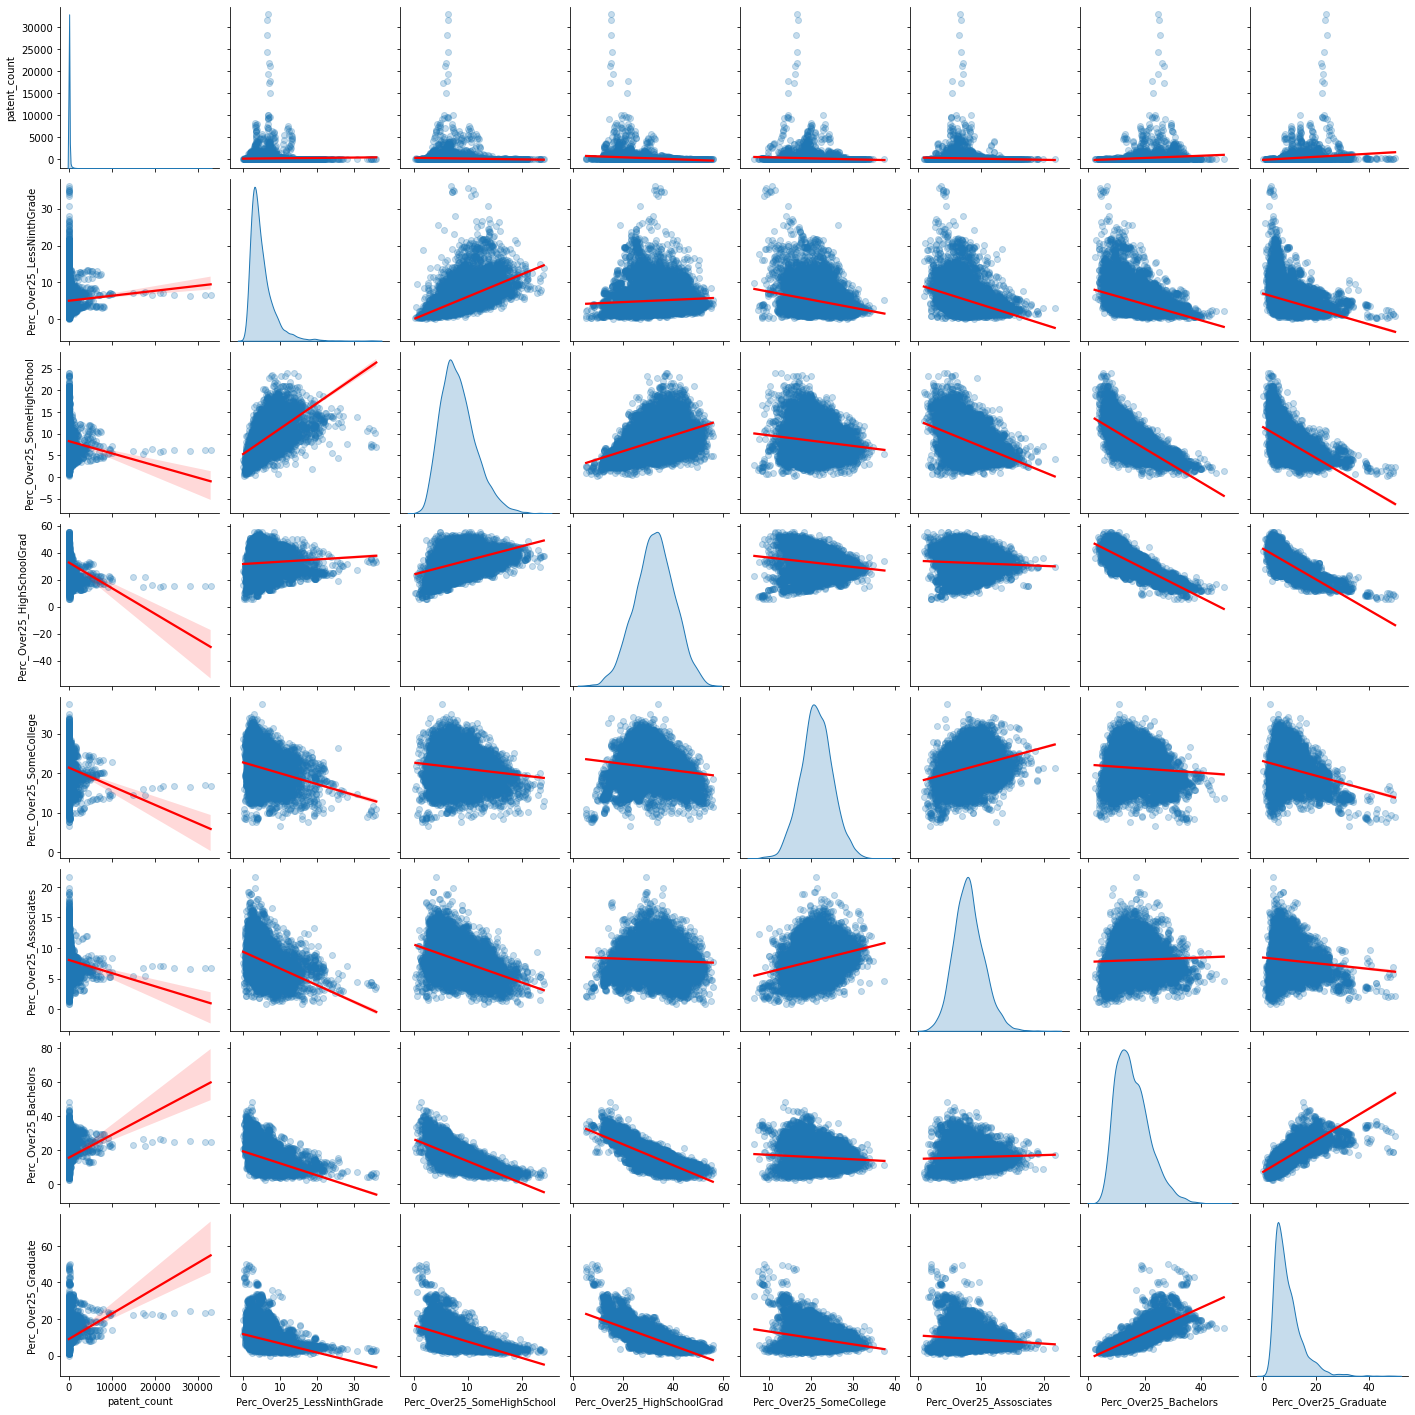

In [149]:

g = sns.pairplot(merged_patents_uni_ed[['patent_count',
 # 'level_r1',
 # 'level_r2',
 # 'special_focus',
 'Perc_Over25_LessNinthGrade',
 'Perc_Over25_SomeHighSchool',
 'Perc_Over25_HighSchoolGrad',
 'Perc_Over25_SomeCollege',
 'Perc_Over25_Assosciates',
 'Perc_Over25_Bachelors',
 'Perc_Over25_Graduate']],
            diag_kind = 'kde',
            kind = 'reg',
            plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.25}})
# for i in range(0,len(cols)):
#     for j in range(0,i):
#         g.axes[i,j].set_xlim((0,100))
#         g.axes[i,j].set_ylim((0,100))
#         g.axes[j,i].set_xlim((0,100))
#         g.axes[j,i].set_ylim((0,100))

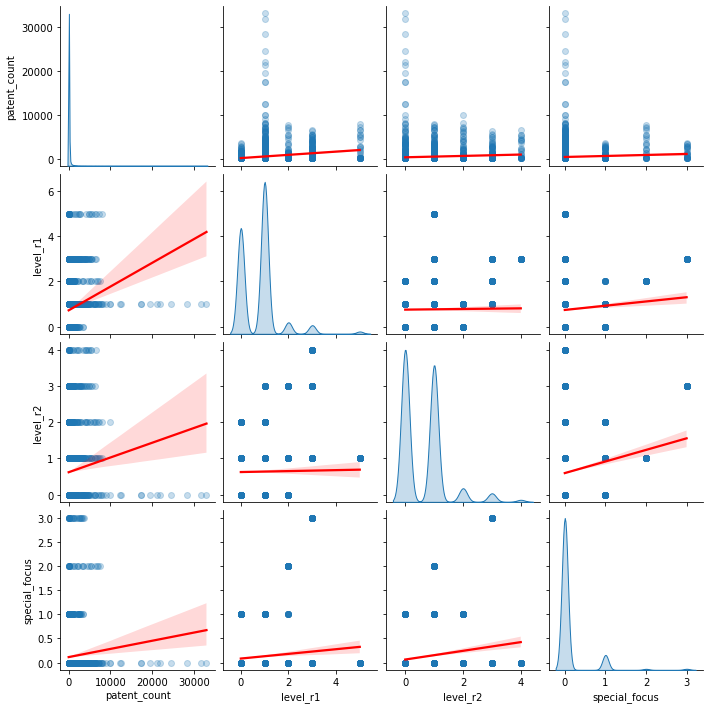

In [148]:

g = sns.pairplot(merged_patents_uni_ed[['patent_count',
 'level_r1',
 'level_r2',
 'special_focus',
 # 'Perc_Over25_LessNinthGrade',
 # 'Perc_Over25_SomeHighSchool',
 # 'Perc_Over25_HighSchoolGrad',
 # 'Perc_Over25_SomeCollege',
 # 'Perc_Over25_Assosciates',
 # 'Perc_Over25_Bachelors',
 # 'Perc_Over25_Graduate'
                        ]],
            diag_kind = 'kde',
            kind = 'reg',
            plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.25}})
# for i in range(0,len(cols)):
#     for j in range(0,i):
#         g.axes[i,j].set_xlim((0,100))
#         g.axes[i,j].set_ylim((0,100))
#         g.axes[j,i].set_xlim((0,100))
#         g.axes[j,i].set_ylim((0,100))